### Model for Predicting Subscription to Term Deposit

In [316]:
# Load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
import tensorflow as tf
import keras as ks
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

<b>Step 1: Dataset Selection</b>
<br>Choose a dataset related to housing prices, either for regression or classification.

   Input variables:
   <b>bank client data</b>
   1 - age (numeric)
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services") 
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4 - education (categorical: "unknown","secondary","primary","tertiary")
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric) 
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   # related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12 - duration: last contact duration, in seconds (numeric)
<b>other attributes</b>
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [106]:
# Import data
df = pd.read_csv("bank-full.csv",sep=";",encoding="utf-8")
# df = pd.read_csv("bank.csv",sep=";",encoding="utf-8")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [107]:
# Drop fields related to the current campaign because we won't have these data when predict next time.
# For example, the data on call duration is only available once the campaign is live/on-going.

df = df.drop(['day','duration','campaign'], axis=1)
df.shape

(45211, 14)

In [108]:
# Show column names and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   month      45211 non-null  object
 10  pdays      45211 non-null  int64 
 11  previous   45211 non-null  int64 
 12  poutcome   45211 non-null  object
 13  y          45211 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.8+ MB


Observation: The data has 45,211 records. There are 9 categorical data including the target variable. There are 4 numerical features.

In [109]:
# Rename specific columns
df = df.rename(columns={'y':'subscribed'})

# Show the updated DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   age         45211 non-null  int64 
 1   job         45211 non-null  object
 2   marital     45211 non-null  object
 3   education   45211 non-null  object
 4   default     45211 non-null  object
 5   balance     45211 non-null  int64 
 6   housing     45211 non-null  object
 7   loan        45211 non-null  object
 8   contact     45211 non-null  object
 9   month       45211 non-null  object
 10  pdays       45211 non-null  int64 
 11  previous    45211 non-null  int64 
 12  poutcome    45211 non-null  object
 13  subscribed  45211 non-null  object
dtypes: int64(4), object(10)
memory usage: 4.8+ MB


In [110]:
# Describe data, show statistics
df.describe()

,age,balance,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,40.197828,0.580323
std,10.618762,3044.765829,100.128746,2.303441
min,18.000000,-8019.000000,-1.000000,0.000000
25%,33.000000,72.000000,-1.000000,0.000000
50%,39.000000,448.000000,-1.000000,0.000000
75%,48.000000,1428.000000,-1.000000,0.000000
max,95.000000,102127.000000,871.000000,275.000000


<b>Step 2: Data Cleaning</b>
<br>Address missing values, handle outliers, and ensure the dataset is ready for exploration.

In [111]:
# Get values of the target variable
print('Original Values:')
print(df['subscribed'].value_counts())

# Transform target variable "Subscribed" to 1/0 value (Subscribed to time deposit: 1, Did not subscribe to time deposit: 0)
df['subscribed'] = df['subscribed'].replace({'yes': 1, 'no': 0})

print('\nTransformed Values:')
print(df['subscribed'].value_counts())

print('\nDistribution:')
print(df['subscribed'].value_counts() / df.shape[0])

Original Values:
no     39922
yes     5289
Name: subscribed, dtype: int64

Transformed Values:
0    39922
1     5289
Name: subscribed, dtype: int64

Distribution:
0    0.883015
1    0.116985
Name: subscribed, dtype: float64


Observation: Only 11.7% of the data subscribe to term deposit, therefore, we have an imbalanced class.

In [112]:
# Check null values
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance       0
housing       0
loan          0
contact       0
month         0
pdays         0
previous      0
poutcome      0
subscribed    0
dtype: int64

Observation: There are no null/missing values.

In [113]:
# Identify categorical and numerical data

# Initiate empty lists
categorical_data = []
numerical_data = []

for i in df.columns:
    # If categorical, append to the list of categorical data
    if df[i].dtype == 'object':
        categorical_data.append(i)
    # Else, append to the list of numerical data
    else:
        numerical_data.append(i)

print(f"Categorical Data : {categorical_data}")
print(f"Numerical Data: {numerical_data}")

Categorical Data : ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical Data: ['age', 'balance', 'pdays', 'previous', 'subscribed']


In [114]:
# Create a summary of column attributes

# Initiate empty lists
count_unique_val = []
count_unknown = []
percent_unknown = []

for column in df:
    # Count unique values for each column
    cnt_unique_val = len(df[column].unique())
    count_unique_val.append(cnt_unique_val)
 
    # Count 'unknown' values for each categorical column
    if column in categorical_data:
        cnt_unknown = len(df[df[column].str.upper()=='UNKNOWN'])
        pcnt_unknown = str(round((cnt_unknown / len(df[column])) * 100, 1)) + '%'
    else:
        cnt_unknown = None
        pcnt_unknown = None        
    count_unknown.append(cnt_unknown)
    percent_unknown.append(pcnt_unknown)

# Count null values for each column    
count_null = df.isnull().sum()

# Count NaN values for each column    
count_nan = df.isna().sum()

# Summarize column attributes using a dataframe
df_summary = pd.DataFrame()
df_summary['column_name'] = []
df_summary['data_type'] = df.dtypes
df_summary['column_name'] = df_summary.index

# Add details
df_summary['count_unique_val'] = count_unique_val
df_summary['count_unknown'] = count_unknown
df_summary['percent_unknown'] = percent_unknown
df_summary['count_null'] = count_null
df_summary['count_nan'] = count_nan

# print(df_summary[df_summary.data_type == 'object'])
# print(df_summary[df_summary.data_type != 'object'])
df_summary

,column_name,data_type,count_unique_val,count_unknown,percent_unknown,count_null,count_nan
age,age,int64,77,NaN,None,0,0
job,job,object,12,288.0,0.6%,0,0
marital,marital,object,3,0.0,0.0%,0,0
education,education,object,4,1857.0,4.1%,0,0
default,default,object,2,0.0,0.0%,0,0
balance,balance,int64,7168,NaN,None,0,0
housing,housing,object,2,0.0,0.0%,0,0
loan,loan,object,2,0.0,0.0%,0,0
contact,contact,object,3,13020.0,28.8%,0,0
month,month,object,12,0.0,0.0%,0,0


Observation: Some features have "unknown" values with POUTCOME having the highest percentage at 81.7%.

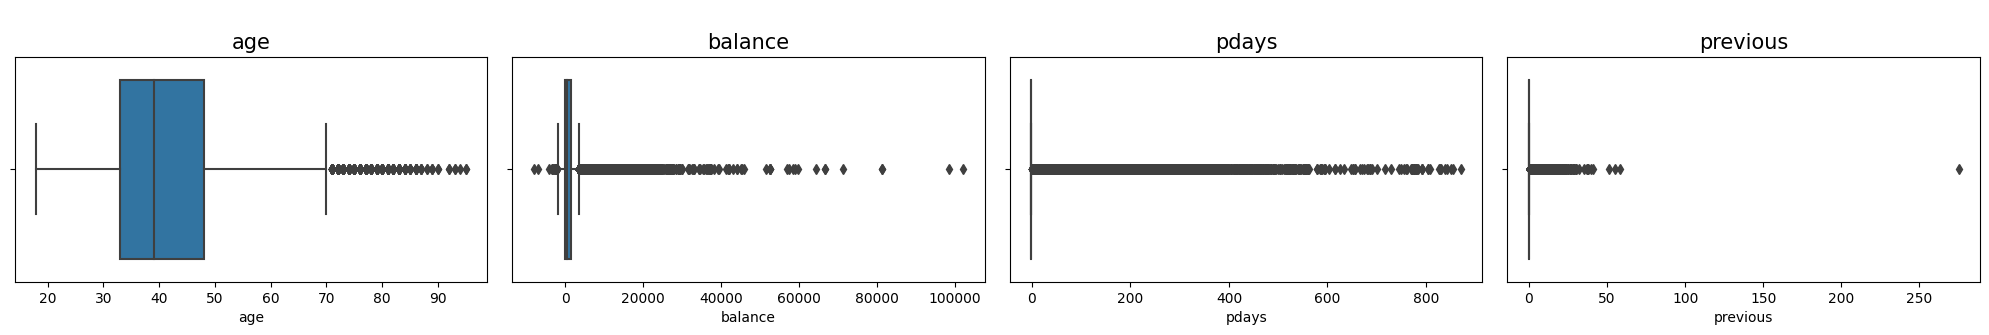

In [115]:
# Display the boxplot of numerical columns

plt.figure(figsize = (20, 20))
plotnumber = 1

for column in numerical_data:
    if column != 'subscribed':
        x = df[column]
        ax = plt.subplot(7, 4, plotnumber)
        sns.boxplot(x = x)
        plt.title(f"\n{df[column].name}", fontsize = 15)
        plotnumber += 1
plt.tight_layout()
plt.show()

Observation: It seems that outliers are present in the data.

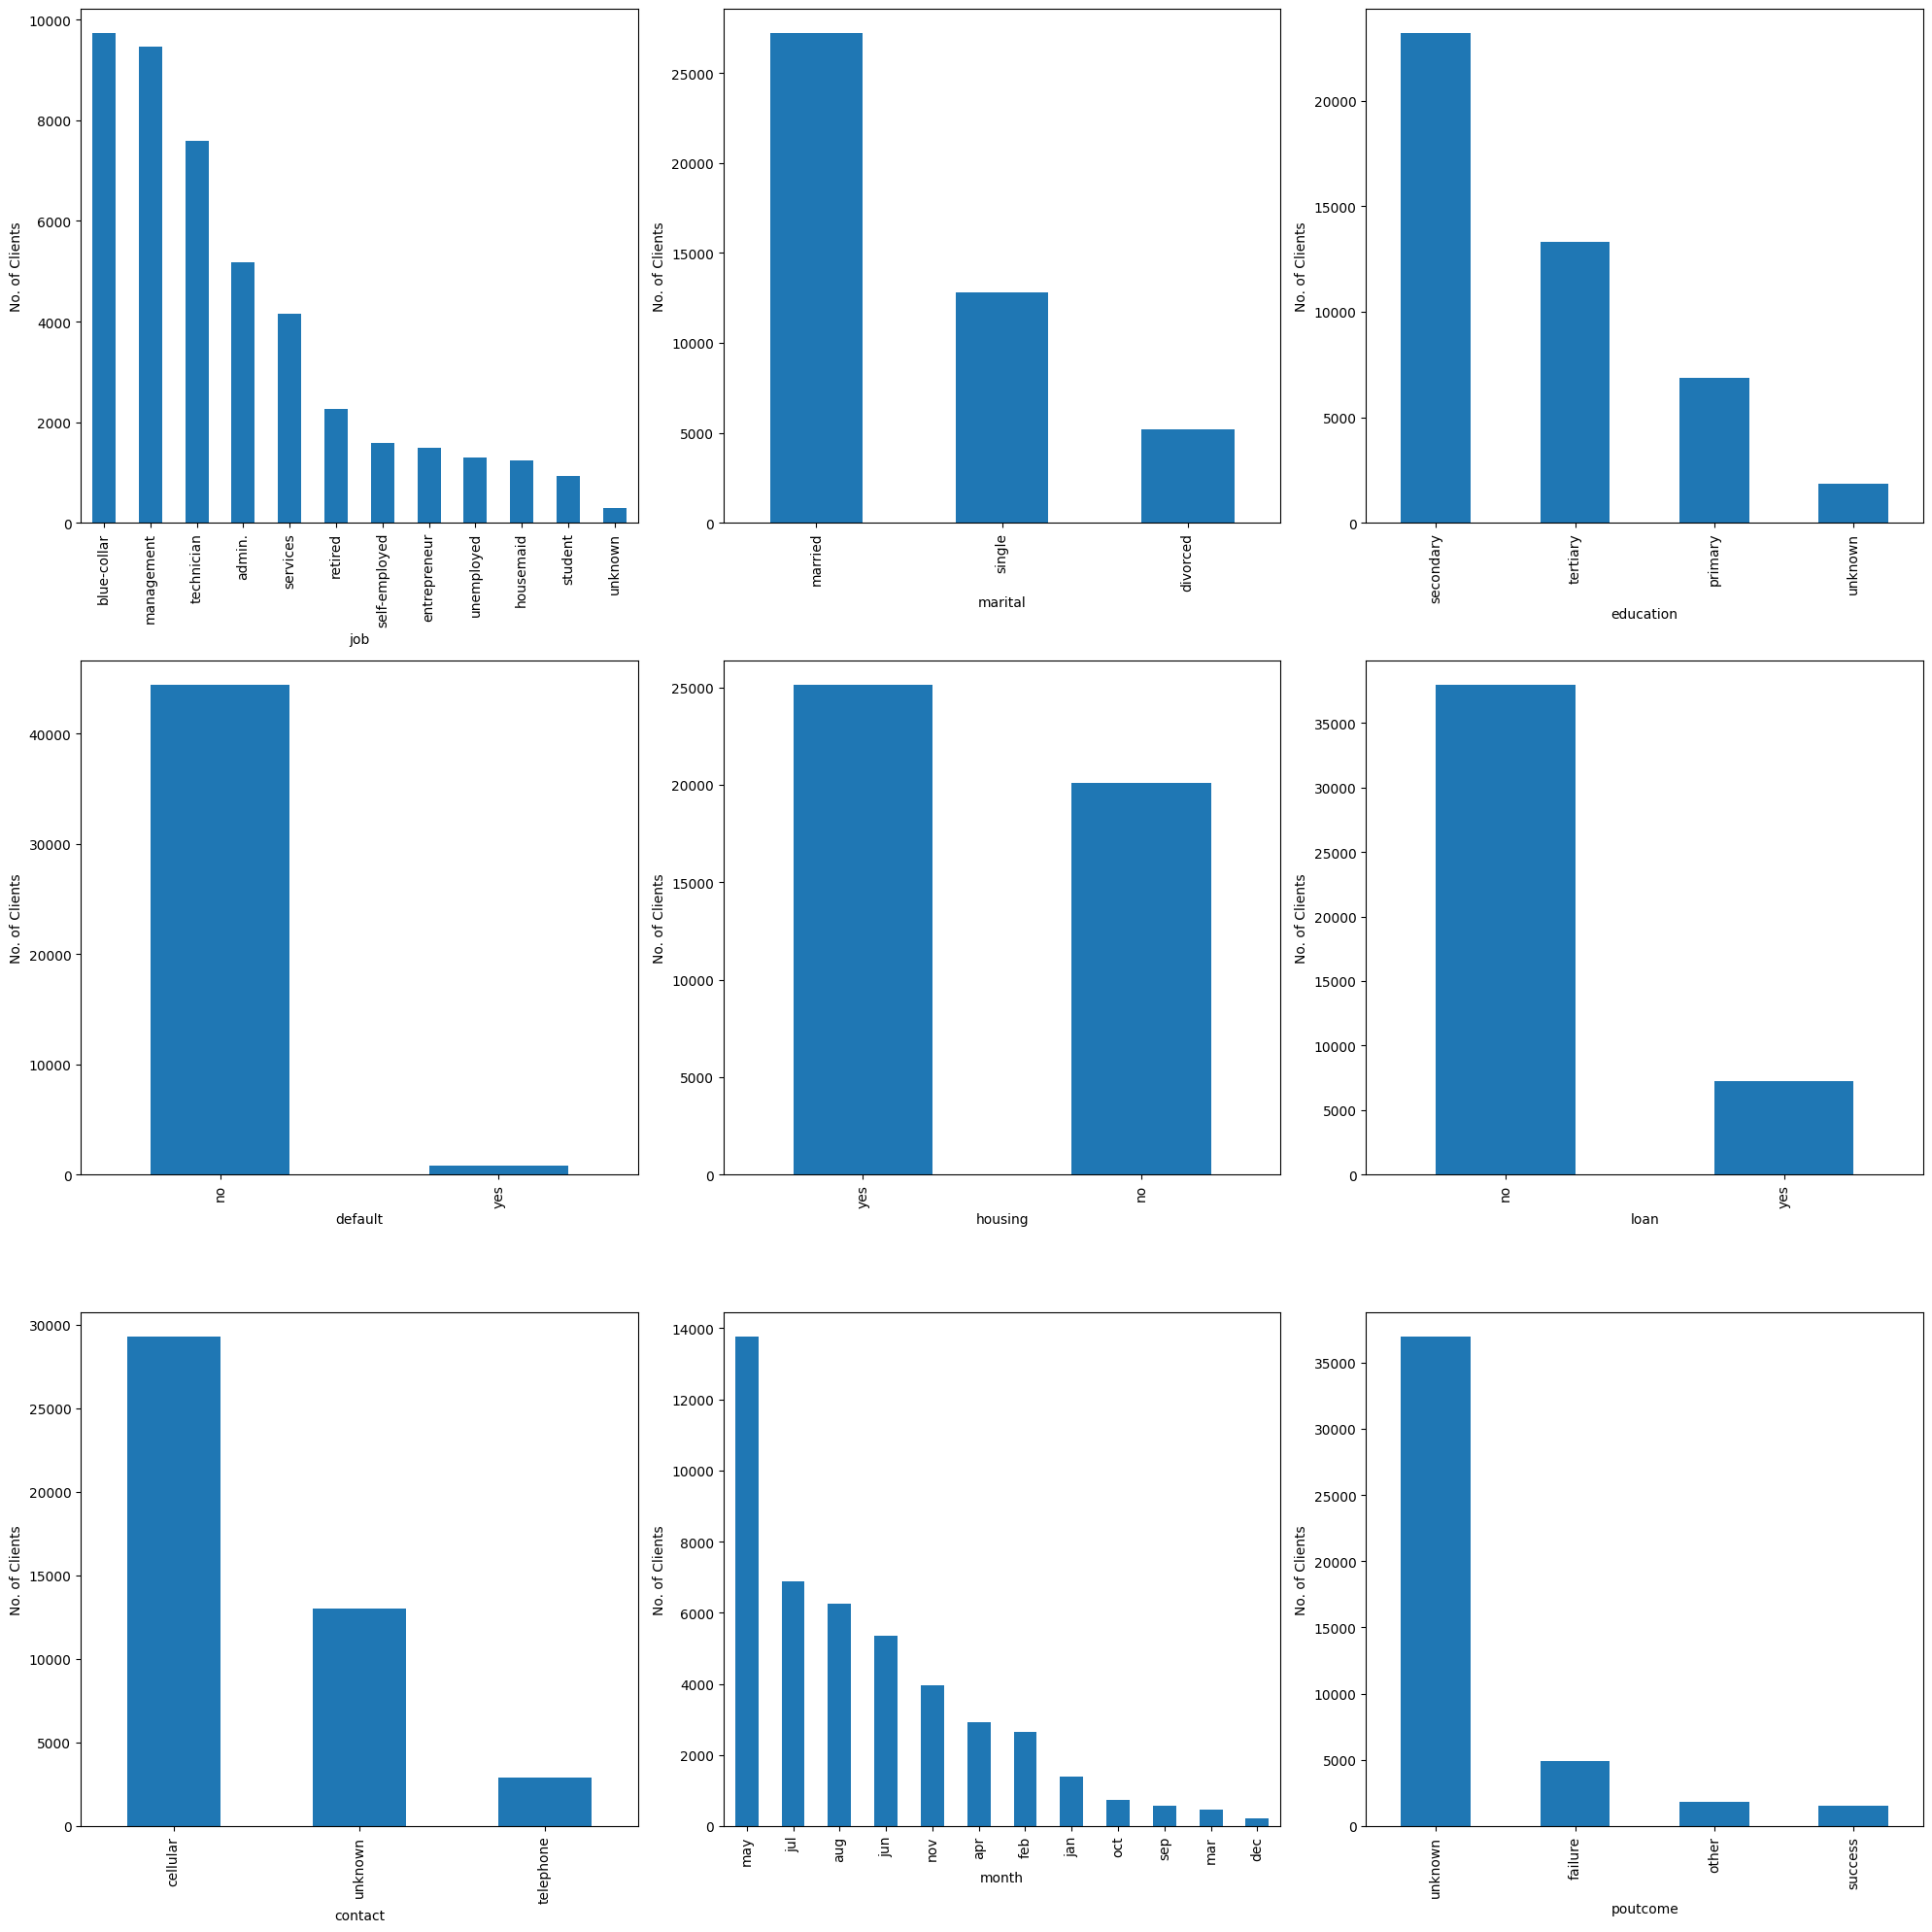

In [116]:
# Display bar chart of categorical columns

plt.figure(figsize = (20, 20))
plotnumber = 1

for column in categorical_data:
    x = df[column]
    ax = plt.subplot(3,3,plotnumber)   
    ax = df[column].value_counts().plot(kind='bar')
    ax.set_xlabel(column)
    ax.set_ylabel("No. of Clients")
    plotnumber += 1

plt.tight_layout()
plt.show()

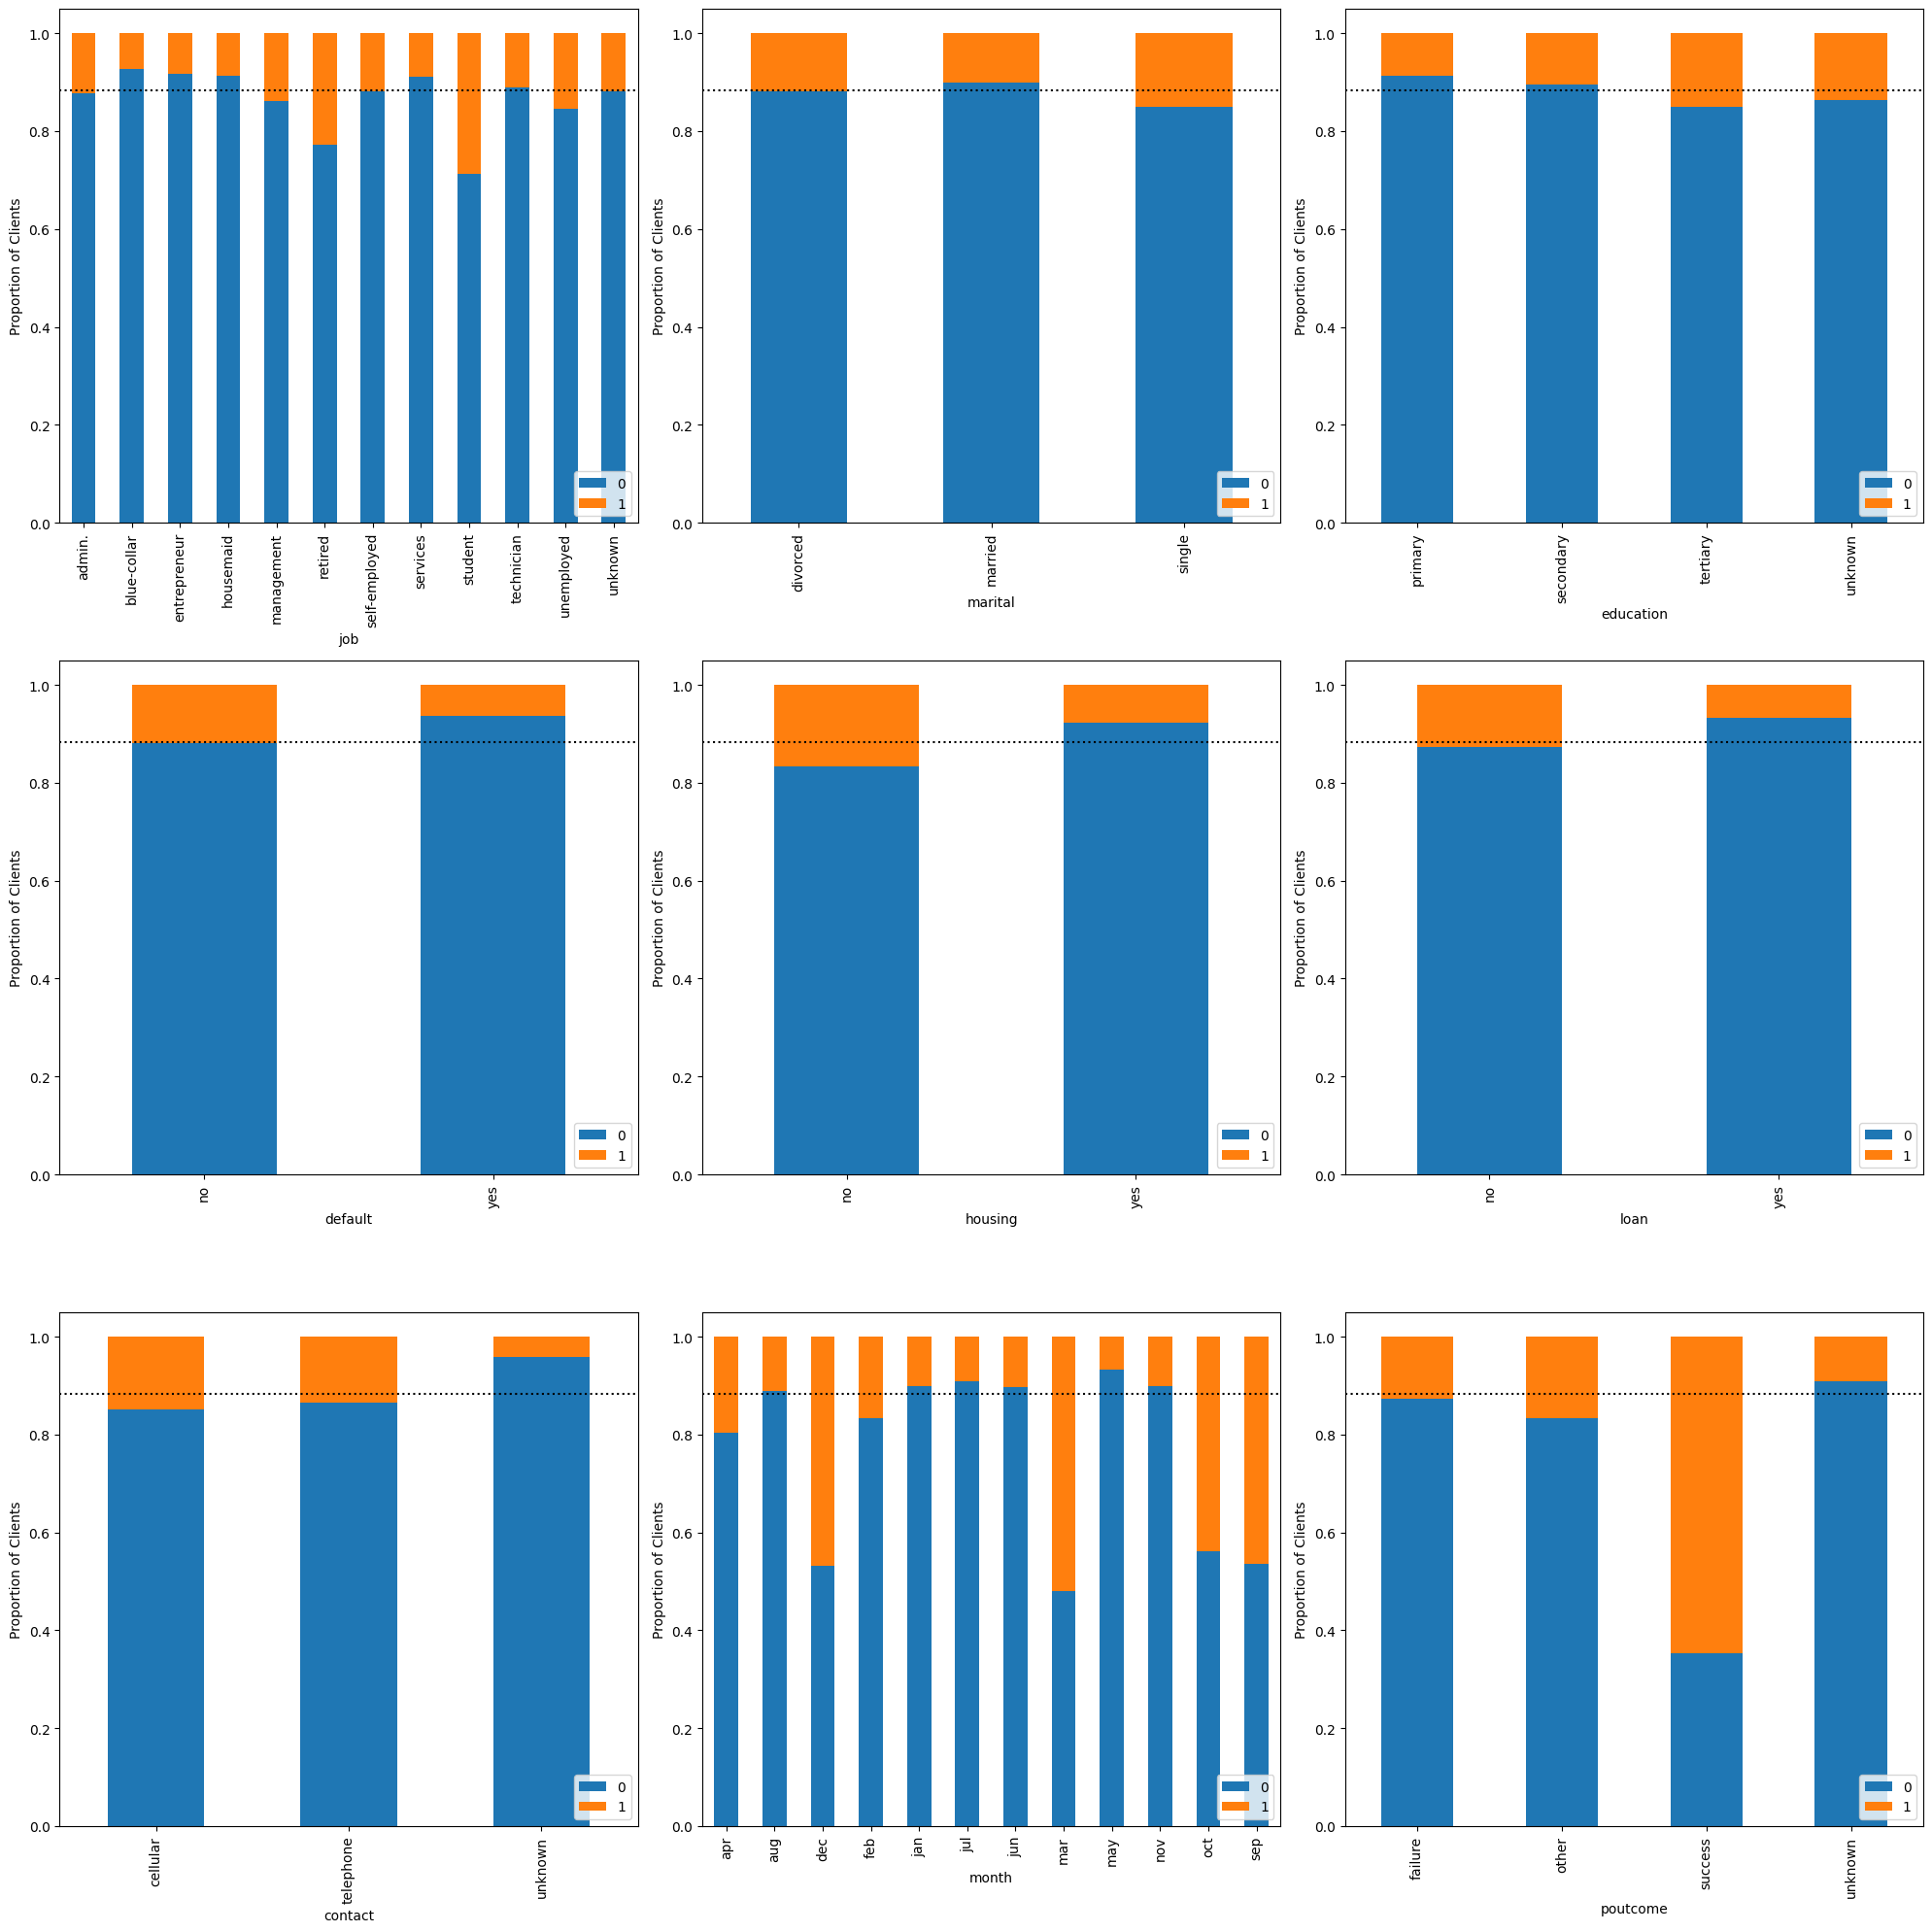

In [117]:
# Display stacked bar chart of categorical columns

plt.figure(figsize = (20, 20))
plotnumber = 1

for column in categorical_data:
    x = df[column]
    ax = plt.subplot(3,3,plotnumber)   
    table=pd.crosstab(df[column],df['subscribed'])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar',ax=ax, stacked=True).legend(loc='lower right')
    plt.ylabel('Proportion of Clients')
    plt.axhline(0.883015, color='black', ls='dotted')  # Baseline: Overall subscription rate
    plotnumber += 1

plt.tight_layout()
plt.show()

Observation: Segments where subscription to term deposit is more prevalent i.e., higher than the 11.7% overall subscription rate.
- job: retired, student, unemployed
- marital: single
- education: tertiary
- default: no
- housing: no
- loan: no
- contact: cellular, telephone
- month: feb, mar, apr, oct, sep, dec
- poutcome: success

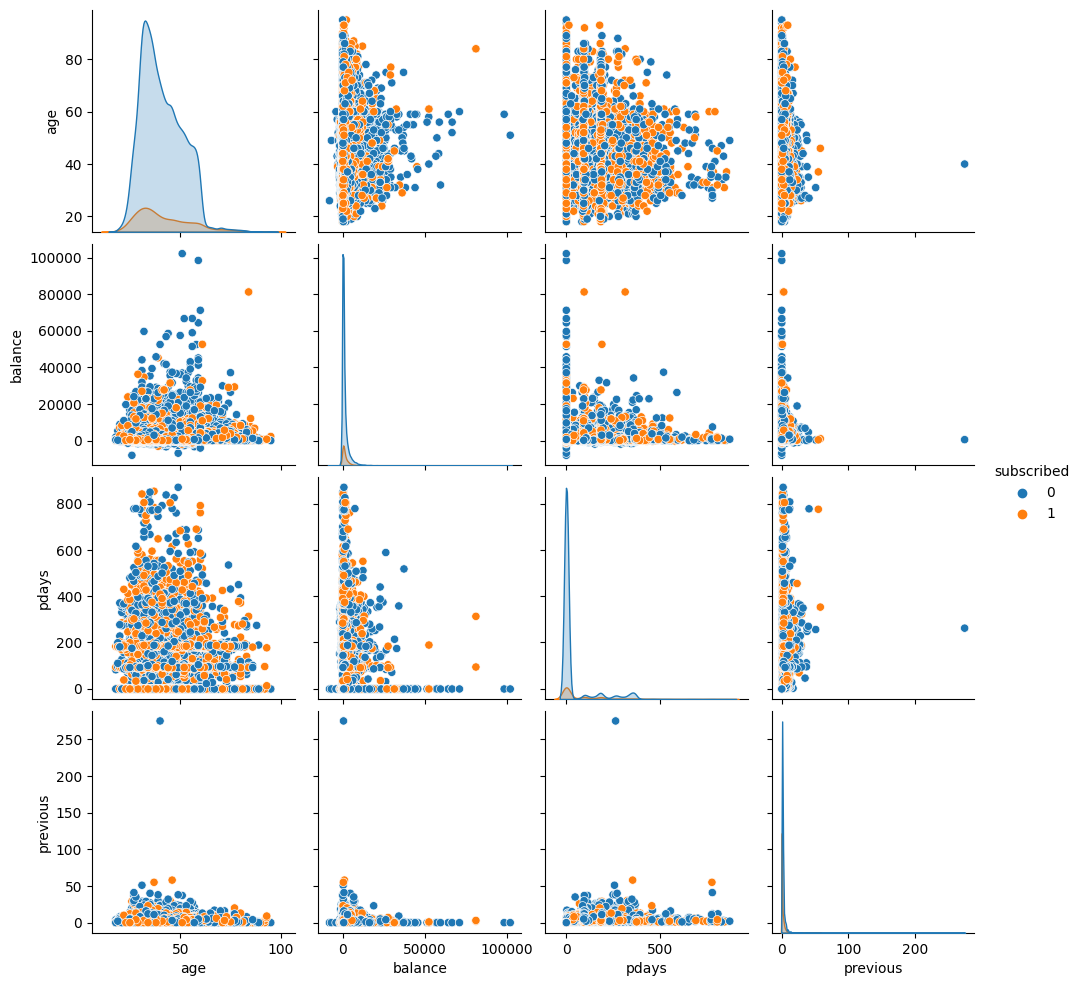

In [118]:
# Plot pairwise bivariate distributions for numerical data and target variable
sns.pairplot(df.select_dtypes(include=np.number),hue='subscribed')

Observation: There are more clients who get term deposit from these segments:
- ___

<b>Step 4: Feature Engineering</b>

In [119]:
# Create a new dataframe for the final data to be used in data modeling
model_data = df
model_data

,age,job,marital,education,default,balance,housing,loan,contact,month,pdays,previous,poutcome,subscribed
0,58,management,married,tertiary,no,2143,yes,no,unknown,may,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,may,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,may,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,may,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,may,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,nov,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,nov,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,nov,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,nov,-1,0,unknown,0


In [120]:
# Encode categorical data to numeric

# Observation: Segments where subscription to term deposit is more prevalent i.e., higher than the 11.7% overall subscription rate.

# - job: retired, student, unemployed
model_data['job_retired_student_unemp'] = model_data['job'].apply(lambda value: 1 if value.lower() in ['retired', 'student', 'unemployed'] else 0)

# - marital: single
model_data['marital_single'] = model_data['marital'].apply(lambda value: 1 if value.lower() == 'single' else 0)

# - education: tertiary
model_data['education_tertiary'] = model_data['education'].apply(lambda value: 1 if value.lower() == 'tertiary' else 0)

# - default: no
model_data['default_yes'] = model_data['default'].apply(lambda value: 1 if value.lower() == 'yes' else 0)

# - housing: no
model_data['housing_yes'] = model_data['housing'].apply(lambda value: 1 if value.lower() == 'yes' else 0)

# - loan: no
model_data['loan_yes'] = model_data['loan'].apply(lambda value: 1 if value.lower() == 'yes' else 0)

# - contact: cellular, telephone
model_data['contact_cellular_telephone'] = model_data['contact'].apply(lambda value: 1 if value.lower() in ['cellular','telephone'] else 0)

# - month: feb, mar, apr, oct, sep, dec
model_data['month_high'] = model_data['month'].apply(lambda value: 1 if value.lower() in ['feb', 'mar', 'apr', 'oct', 'sep', 'dec'] else 0)

# - poutcome: success
model_data['poutcome_success'] = model_data['poutcome'].apply(lambda value: 1 if value.lower() == 'success' else 0)

model_data = model_data.drop(['job','marital','education','default','housing','loan','contact','month','poutcome'], axis=1)

model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   age                         45211 non-null  int64
 1   balance                     45211 non-null  int64
 2   pdays                       45211 non-null  int64
 3   previous                    45211 non-null  int64
 4   subscribed                  45211 non-null  int64
 5   job_retired_student_unemp   45211 non-null  int64
 6   marital_single              45211 non-null  int64
 7   education_tertiary          45211 non-null  int64
 8   default_yes                 45211 non-null  int64
 9   housing_yes                 45211 non-null  int64
 10  loan_yes                    45211 non-null  int64
 11  contact_cellular_telephone  45211 non-null  int64
 12  month_high                  45211 non-null  int64
 13  poutcome_success            45211 non-null  int64
dtypes: int

Observation: After encoding, all features are now numerical.

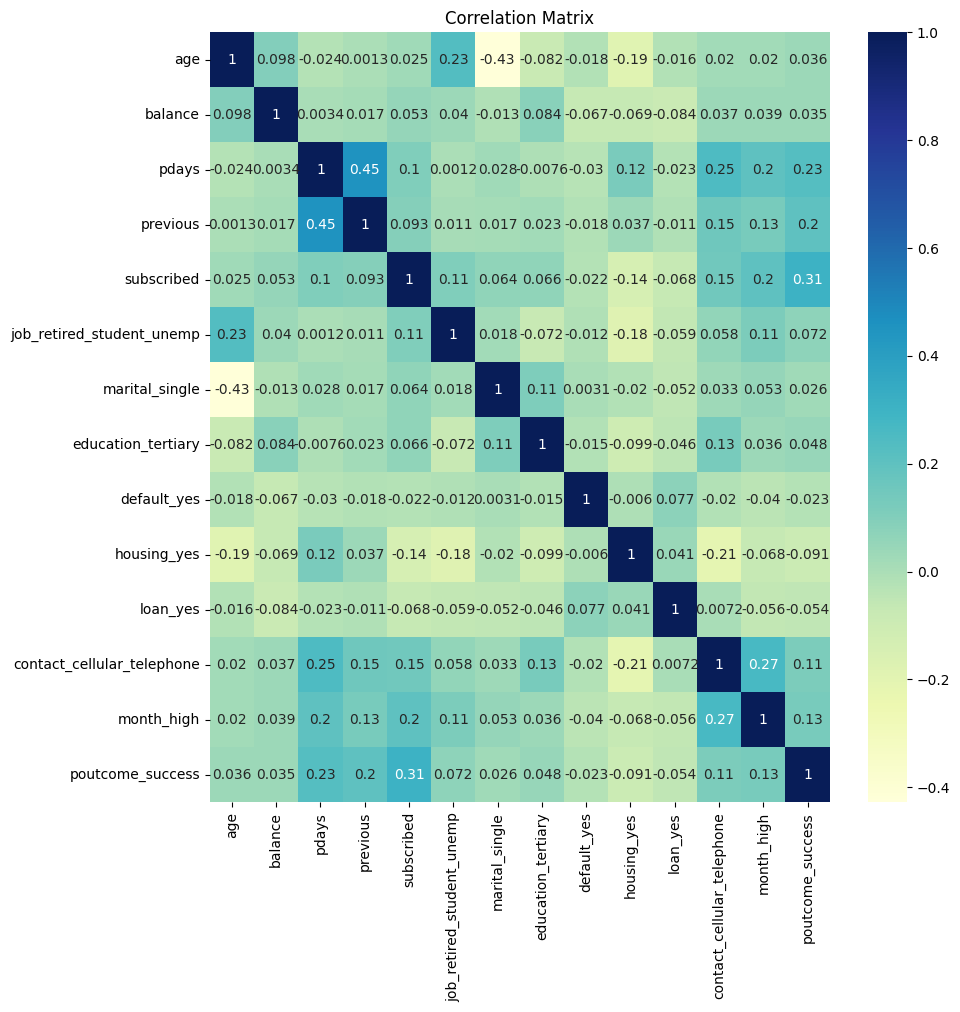

In [121]:
# Correlation Heat Map: Pairwise correlation

plt.figure(figsize=(10,10))
sns.heatmap(model_data.corr(), annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

Observation: previous (number of contacts performed before this campaign) and pdays (number of days that passed by after the client was last contacted from a previous campaign) have higher correlation with each other compared to other features. None of the numerical features show high correlation with the target variable (subscribed).

In [128]:
# Variance Inflation Factor

def VIF(independent_variable):
    vif = pd.DataFrame()
    vif['feature'] = independent_variable.columns
    vif['vif_factor'] = [variance_inflation_factor(independent_variable.values,i) for i in range(independent_variable.shape[1])]
    return vif.sort_values('vif_factor')

VIF(model_data.drop(['subscribed'], axis=1))

,feature,vif_factor
7,default_yes,1.028686
12,poutcome_success,1.134672
9,loan_yes,1.210104
4,job_retired_student_unemp,1.228853
1,balance,1.237733
11,month_high,1.352485
5,marital_single,1.360949
3,previous,1.361787
6,education_tertiary,1.471892
2,pdays,1.634415


Observation: There is no VIF greater than 5 which means that none of the features is highly correlated with another feature.

## Data Modeling 

In [129]:
# Get target and features
y_var = model_data['subscribed']
x_vars = model_data.drop(['subscribed'], axis=1)

print('y data:',y_var.shape)
print('x data:',x_vars.shape)

y data: (45211,)
x data: (45211, 13)


In [247]:
# Split the data into training (80%) and test (20%) sets
x_train, x_test, y_train, y_test = train_test_split(x_vars,y_var,test_size=0.2,random_state=1234)

print('X Train:',x_train.shape)
print('Y Train:',y_train.shape)
print('X Test:',x_test.shape)
print('Y Test:',y_test.shape)

X Train: (36168, 13)
Y Train: (36168,)
X Test: (9043, 13)
Y Test: (9043,)


In [248]:
# Function to check for outliers and cap values of outliers
def CheckOutliers(inData,inNumericalFeatures):
    
    # Initialize blank dataframes and dictionary
    outTrain = pd.DataFrame()
    outlier_limits = {}
    
    # Loop through all numerical features
    for colName in inData.columns:
        
        if colName in inNumericalFeatures:
            
            # Compute for lower/upper limits using the training data
            quartile_75, quartile_q25 = np.percentile(inData.loc[:,colName],[75,25])   # 75th and 25th percentiles
            interquartile_range = quartile_75 - quartile_q25                            # Interquartile range (IQR)
            min_val = quartile_q25 - ( 1.5 * interquartile_range )                      # Lower limit
            max_val = quartile_75 + ( 1.5 * interquartile_range )                       # Upper limit
                        
            # Add to dictionary
            if min_val != max_val:
                outlier_limits[colName] = [min_val,max_val]
                
    return outlier_limits

# Get outlier limits based on training data
outlier_limits = CheckOutliers(x_train,[col for col in numerical_data if col not in ['pdays']])
outlier_limits

{'age': [10.5, 70.5], 'balance': [-1965.0, 3467.0]}

In [191]:
# Create pickle file
pickle.dump(outlier_limits,open("outlier_limits.pkl",'wb'))

# Get pickle file
# outlier_limits = pickle.load(open("outlier_limits.pkl",'rb'))

In [249]:
# Function to check for outliers and cap values of outliers
def RemoveOutliers(inData,inOutliers):
    
    # Initialize blank dataframes
    # outData = pd.DataFrame()
    outData = inData
    
    # Loop through all features
    for colName in inData.columns:
        
        if colName in list(inOutliers.keys()):
            
            min_val = inOutliers.get(colName)[0]  # Lower limit
            max_val = inOutliers.get(colName)[1]  # Upper limit
            
            # If the value is lower/greater than the min/max limits, it is an outlier
            outliers = inData[(inData[colName] < min_val) | (inData[colName] > max_val)]
            
            # For outliers, apply capping -- replace the value with either the lower or upper limit
            outData[colName] = np.where( inData[colName] > max_val, max_val, np.where( inData[colName] < min_val, min_val, inData[colName] ) )
            
            # Summary per feature
            print(f'No. of outliers for {colName}: {outliers.shape[0]} \t\tLimits: {round(min_val,4)} , {round(max_val,4)}')
            
        else:
            outData[colName] = inData[colName].values
    
    return outData

# Check and handle outliers of the data. For the test set, the lower/upper limits will be the same as the training set.
print('\nRemove outliers - Train Set')
x_train_no_outliers = RemoveOutliers(x_train,outlier_limits)

print('\nRemove outliers - Test Set')
x_test_no_outliers = RemoveOutliers(x_test,outlier_limits)


Remove outliers - Train Set
No. of outliers for age: 376 		Limits: 10.5 , 70.5
No. of outliers for balance: 3770 		Limits: -1965.0 , 3467.0

Remove outliers - Test Set
No. of outliers for age: 111 		Limits: 10.5 , 70.5
No. of outliers for balance: 943 		Limits: -1965.0 , 3467.0


Observation: There are outliers in the data. It's higher in "balance" where 3,770 out of 36,168 (10%) of the values in the training ser are outliers.

In [238]:
# Scale the data
# scaler = MinMaxScaler()
scaler = StandardScaler()

x_train_sc = scaler.fit_transform(x_train_no_outliers)
x_test_sc = scaler.transform(x_test_no_outliers)

In [320]:
# Function to evaluate the model
def ModelEval(yActual,yPred):

    # Create a summary of model scores
    model_score_list = ['classification accuracy','precision','recall','f1 score',
                        # 'ROC AUC'
                        ]
    model_score = pd.DataFrame(pd.Series(model_score_list))
    model_score.set_index(0, inplace=True)

    # yActual = sample_data[0]
    # yPred = sample_data[1]

    # Accuracy
    rowIndex = model_score.index[0]
    model_score.loc[rowIndex, '1 - Yes'] = np.nan
    model_score.loc[rowIndex, '0 - No'] = np.nan
    model_score.loc[rowIndex, 'weighted ave'] = accuracy_score(yActual, yPred).round(2)
    model_score

    # Precision
    rowIndex = model_score.index[1] 
    model_score.loc[rowIndex, '1 - Yes'] = precision_score(yActual,yPred, pos_label=1).round(2)
    model_score.loc[rowIndex, '0 - No'] = precision_score(yActual,yPred, pos_label=0).round(2)
    model_score.loc[rowIndex, 'weighted ave'] = precision_score(yActual,yPred, average='weighted').round(2)

    # Recall
    rowIndex = model_score.index[2]
    model_score.loc[rowIndex, '1 - Yes'] = recall_score(yActual,yPred, pos_label=1).round(2)
    model_score.loc[rowIndex, '0 - No'] = recall_score(yActual,yPred, pos_label=0).round(2)
    model_score.loc[rowIndex, 'weighted ave'] = recall_score(yActual,yPred, average='weighted').round(2)

    # F1 Score
    rowIndex = model_score.index[3]
    model_score.loc[rowIndex, '1 - Yes'] = f1_score(yActual,yPred, pos_label=1).round(2)
    model_score.loc[rowIndex, '0 - No'] = f1_score(yActual,yPred, pos_label=0).round(2)
    model_score.loc[rowIndex, 'weighted ave'] = f1_score(yActual,yPred, average='weighted').round(2)
    
    return model_score

In [328]:
# Decision Tree hyperparameter tuning

dtree_params = [{'min_samples_leaf': [40000], 'max_depth': list(range(30,50))}]
grid_search_cv = GridSearchCV(DecisionTreeClassifier(), dtree_params, verbose=1, cv=10, scoring='accuracy')
grid_search_cv.fit(x_train_sc, y_train)

# forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]
# clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy')

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid=[{'max_depth': [30, 31, 32, 33, 34, 35, 36, 37, 38, 39,
                                        40, 41, 42, 43, 44, 45, 46, 47, 48,
                                        49],
                          'min_samples_leaf': [40000]}],
             scoring='accuracy', verbose=1)

In [330]:
# Best hyperparameters for Decision Tree
# grid_search_cv.best_params_
print('Score:',grid_search_cv.best_score_)
grid_search_cv.best_estimator_

Score: 0.8827140029506679


DecisionTreeClassifier(max_depth=30, min_samples_leaf=40000)

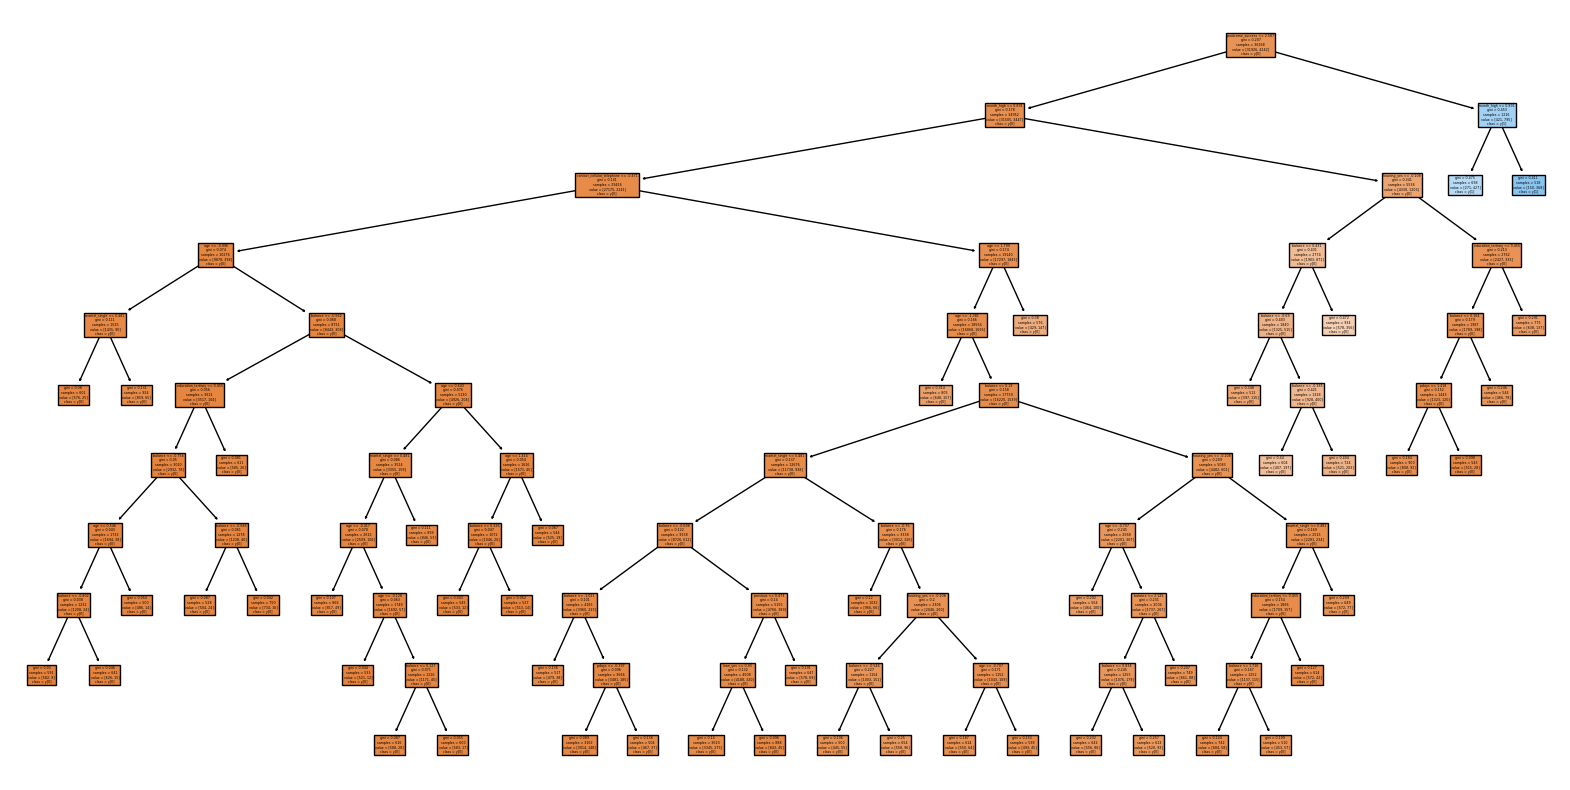

In [331]:
model_dtree = DecisionTreeClassifier(random_state = 42, min_samples_leaf=500, max_depth=10)
model_dtree.fit(x_train_sc, y_train)

# Plot decision tree
fig = plt.figure(figsize = (20, 10))
tree.plot_tree(model_dtree, feature_names = list(x_train.columns), class_names = True, filled = True)
plt.show()

In [332]:
# Predict values
y_pred_train_dtree = model_dtree.predict(x_train_sc)
y_pred_test_dtree = model_dtree.predict(x_test_sc)

In [333]:
print('Decision Tree - TRAIN')
print(ModelEval(y_train,y_pred_train_dtree))

print('\n\nDecision Tree - TEST')
print(ModelEval(y_test,y_pred_test_dtree))

Decision Tree - TRAIN
                         1 - Yes  0 - No  weighted ave
0                                                     
classification accuracy      NaN     NaN          0.89
precision                   0.65    0.90          0.87
recall                      0.19    0.99          0.89
f1 score                    0.29    0.94          0.87


Decision Tree - TEST
                         1 - Yes  0 - No  weighted ave
0                                                     
classification accuracy      NaN     NaN          0.89
precision                   0.62    0.90          0.87
recall                      0.17    0.99          0.89
f1 score                    0.27    0.94          0.86


                       Feature  Feature Importance
0                          age            0.044666
1                      balance            0.037917
2                        pdays            0.001978
3                     previous            0.001210
5               marital_single            0.006118
6           education_tertiary            0.006193
8                  housing_yes            0.092981
9                     loan_yes            0.000767
10  contact_cellular_telephone            0.037241
11                  month_high            0.162059
12            poutcome_success            0.608871


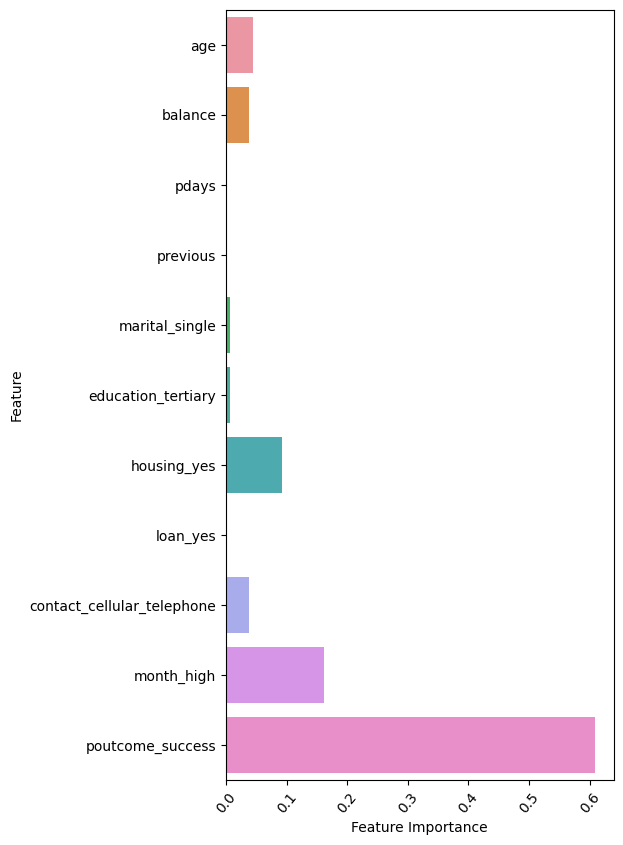

In [334]:
# Summary of Decision Tree Features 
summary_dtree = pd.DataFrame()
summary_dtree['Feature'] = x_train.columns
summary_dtree['Feature Importance'] = model_dtree.feature_importances_
summary_dtree = summary_dtree[summary_dtree['Feature Importance']>0]
print(summary_dtree)

# Plot feature importance
fig = plt.figure(figsize = (5, 10))
sns.barplot(x=summary_dtree['Feature Importance'], y=summary_dtree['Feature'])
plt.xticks(rotation = 50)
plt.show()

In [354]:
# Split the data intro training and validation sets
x_train_ann, x_valid_ann, y_train_ann, y_valid_ann = train_test_split(x_train_sc,y_train,test_size=0.2,random_state=1234)

print('X Train - ANN:',x_train_ann.shape)
print('Y Train - ANN:',y_train_ann.shape)
print('X Valid - ANN:',x_valid_ann.shape)
print('Y Valid - ANN:',y_valid_ann.shape)

X Train - ANN: (28934, 13)
Y Train - ANN: (28934,)
X Valid - ANN: (7234, 13)
Y Valid - ANN: (7234,)


In [355]:
# Set up the layers of ANN

ann_layers = [tf.keras.layers.Dense(units=50, input_shape=x_train_ann.shape[1:], name="inputLayer"),
              tf.keras.layers.Dense(100, activation="relu", name="hiddenLayer1"),
            #   layers.Dropout(0.3),
            # tf.keras.layers.Dense(200, activation="relu", name="hiddenLayer2"),              
              tf.keras.layers.Dense(50, activation="relu", name="hiddenLayer2"),
              tf.keras.layers.Dense(1, activation="sigmoid", name="outputLayer")]

# Notes:
# - Model was overfitted when a 2nd hidden layer with 200 nodes was added
# - Adding dropout reduced overfitting of the model

model_ann = tf.keras.models.Sequential(ann_layers)

print('Layers:\n')
print(model_ann.layers)
print('\n\nSummary:\n')
print(model_ann.summary())

Layers:

[<keras.src.layers.core.dense.Dense object at 0x000002284F0A16C0>, <keras.src.layers.core.dense.Dense object at 0x0000022852B953C0>, <keras.src.layers.core.dense.Dense object at 0x0000022852B94F10>, <keras.src.layers.core.dense.Dense object at 0x0000022852B94E50>]


Summary:

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (Dense)          (None, 50)                700       
                                                                 
 hiddenLayer1 (Dense)        (None, 100)               5100      
                                                                 
 hiddenLayer2 (Dense)        (None, 50)                5050      
                                                                 
 outputLayer (Dense)         (None, 1)                 51        
                                                                 
Total params: 10901 (42.58 KB)
T

Epoch 1/10
905/905 [==============================] - 2s 2ms/step - loss: 0.3368 - accuracy: 0.8864 - val_loss: 0.3082 - val_accuracy: 0.8915
Epoch 2/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3067 - accuracy: 0.8932 - val_loss: 0.3056 - val_accuracy: 0.8918
Epoch 3/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3046 - accuracy: 0.8929 - val_loss: 0.3055 - val_accuracy: 0.8912
Epoch 4/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3034 - accuracy: 0.8931 - val_loss: 0.3044 - val_accuracy: 0.8926
Epoch 5/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3027 - accuracy: 0.8935 - val_loss: 0.3047 - val_accuracy: 0.8916
Epoch 6/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3022 - accuracy: 0.8932 - val_loss: 0.3044 - val_accuracy: 0.8907
Epoch 7/10
905/905 [==============================] - 1s 1ms/step - loss: 0.3017 - accuracy: 0.8937 - val_loss: 0.3036 - val_accuracy: 0.8922
Epoch 

<AxesSubplot: >

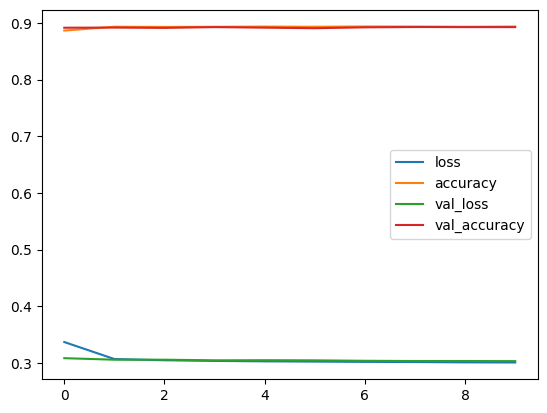

In [357]:
# Compile the ANN model

model_ann.compile(loss="binary_crossentropy",
                  optimizer="SGD",
                  metrics=["accuracy"])

# Training

history = model_ann.fit(x_train_ann, y_train_ann, epochs=10,
                        validation_data=(x_valid_ann, y_valid_ann),
                        batch_size=32)

# Plot
pd.DataFrame(history.history).plot()

In [359]:
# Predict the values of y
# y_pred_train_ann = model_ann.predict(x_train_ann, verbose=0)
# y_pred_test_ann = model_ann.predict(x_test_sc, verbose=0)

# print('ANN - TRAIN')
# print(ModelEval(y_train_ann,y_pred_train_ann))

# print('\n\nANN  - TEST')
# print(ModelEval(y_test,y_pred_test_ann))


# Evaluate the model using test data

test_loss, test_acc = model_ann.evaluate(x_test_sc, y_test, verbose=2)

print('\nTest Accuracy:', test_acc)
print('Test Loss:', test_loss)

283/283 - 0s - loss: 0.3044 - accuracy: 0.8927 - 220ms/epoch - 776us/step

Test Accuracy: 0.892734706401825
Test Loss: 0.30438539385795593


In [ ]:
scalar=MinMaxScaler()
column=numeric_columns.columns
numeric_cols=scalar.fit_transform(numeric_columns)
df_numeric=pd.DataFrame(numeric_cols,columns=column)
df_numeric.head()

In [123]:
def vif_factor(independant_variable):
    
    vif=pd.DataFrame()
    vif['feature']=independant_variable.columns
    vif['vif_factor']=[variance_inflation_factor(independant_variable.values,i) for i in range(independant_variable.shape[1])]
    return vif.sort_values('vif_factor')

vif_factor(model_data)

,feature,vif_factor
8,default_yes,1.028701
10,loan_yes,1.211503
13,poutcome_success,1.218443
5,job_retired_student_unemp,1.231902
1,balance,1.238508
4,subscribed,1.317134
3,previous,1.361967
6,marital_single,1.366621
12,month_high,1.375004
7,education_tertiary,1.473787


In [ ]:
df

In [ ]:
# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=.7)
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
#plt.figure(figsize=(10, 8)) 
#df_new = df.select_dtypes(include=['number'])
#sns.heatmap(df_new.corr(),annot=True)

In [21]:
df = pd.read_csv("first_version.csv",sep=",")

In [67]:
# Function to check for outliers and cap values of outliers
def CheckOutliers(inTrain,inTest):
    
    # Initialize blank dataframes
    outTrain = pd.DataFrame()
    outTest = pd.DataFrame()
    
    # Loop through all features
    for colName in inTrain.columns:
        
        # Compute for lower/upper limits using the training data
        quartile_75, quartile_q25 = np.percentile(inTrain.loc[:,colName],[75,25])   # 75th and 25th percentiles
        interquartile_range = quartile_75 - quartile_q25                            # Interquartile range (IQR)
        max_val = quartile_75 + ( 1.5 * interquartile_range )                       # Upper limit
        min_val = quartile_q25 - ( 1.5 * interquartile_range )                      # Lower limit
        
        # If the value is lower/greater than the min/max limits, it is an outlier
        outliers = inTrain[(inTrain[colName] < min_val) | (inTrain[colName] > max_val)]
        
        # For outliers, apply capping -- replace the value with either the lower or upper limit
        outTrain[colName] = np.where( inTrain[colName] > max_val, max_val, np.where( inTrain[colName] < min_val, min_val, inTrain[colName] ) )

        # Apply capping to the test set using the same lower/upper limit in the train set
        outTest[colName] = np.where( inTest[colName] > max_val, max_val, np.where( inTest[colName] < min_val, min_val, inTest[colName] ) )
        
        # Summary per feature
        print(f'Train -- No. of outliers for {colName}: {outliers.shape[0]} \tLimits: {round(min_val,4)} , {round(max_val,4)}')
    
    return outTrain, outTest

# df_x_train_sc = pd.DataFrame(x_train_sc,columns=x_train.columns)

# Check and handle outliers of the data. For the test set, the lower/upper limits will be the same as the training set.
x_train_no_outliers, x_test_no_outliers = CheckOutliers(x_train,x_test)
# x_train_no_outliers.head()

Train -- No. of outliers for age: 322 	Limits: 9.5 , 69.5
Train -- No. of outliers for job: 1349 	Limits: -2.5 , 9.5
Train -- No. of outliers for marital: 61 	Limits: -0.5 , 3.5
Train -- No. of outliers for education: 1187 	Limits: -0.5 , 11.5
Train -- No. of outliers for default: 6039 	Limits: 0.0 , 0.0
Train -- No. of outliers for housing: 0 	Limits: -1.5 , 2.5
Train -- No. of outliers for loan: 5041 	Limits: 0.0 , 0.0
Train -- No. of outliers for contact: 0 	Limits: -1.5 , 2.5
Train -- No. of outliers for month: 0 	Limits: 0.5 , 12.5
Train -- No. of outliers for day_of_week: 0 	Limits: -1.0 , 7.0
Train -- No. of outliers for duration: 2068 	Limits: -222.0 , 642.0
Train -- No. of outliers for campaign: 1668 	Limits: -2.0 , 6.0
Train -- No. of outliers for pdays: 1033 	Limits: 0.0 , 0.0
Train -- No. of outliers for previous: 3906 	Limits: 0.0 , 0.0
Train -- No. of outliers for poutcome: 3906 	Limits: -1.0 , -1.0
Train -- No. of outliers for emp.var.rate: 0 	Limits: -6.6 , 6.2
Train --

In [35]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.conf.idx,y
0,56,10,1,2,0,0,0,0,5,1,261,1,0,0,-1,1.1,-36.4,0
1,57,1,1,5,-1,0,0,0,5,1,149,1,0,0,-1,1.1,-36.4,0
2,37,1,1,5,0,1,0,0,5,1,226,1,0,0,-1,1.1,-36.4,0
3,40,2,1,3,0,0,0,0,5,1,151,1,0,0,-1,1.1,-36.4,0
4,56,1,1,5,0,0,1,0,5,1,307,1,0,0,-1,1.1,-36.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,1,6,0,1,0,1,11,5,334,1,0,0,-1,-1.1,-50.8,1
41184,46,3,1,6,0,0,0,1,11,5,383,1,0,0,-1,-1.1,-50.8,0
41185,56,5,1,7,0,1,0,1,11,5,189,2,0,0,-1,-1.1,-50.8,0
41186,44,4,1,6,0,0,0,1,11,5,442,1,0,0,-1,-1.1,-50.8,1


In [96]:

def vif_factor(independant_variable):
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif=pd.DataFrame()
    vif['feature']=independant_variable.columns
    vif['vif_factor']=[variance_inflation_factor(independant_variable.values,i) for i in range(independant_variable.shape[1])]
    return vif.sort_values('vif_factor')


Columns with High Correlation:
{'contact_cellular_telephone', 'default_yes'}


In [41]:
vif_factor(df)

,feature,vif_factor
6,loan,1.163820
4,default,1.419480
17,y,1.597387
12,pdays,1.623030
15,emp.var.rate,1.663399
11,campaign,1.916956
5,housing,1.951871
10,duration,2.437694
1,job,3.368908
7,contact,4.038750


In [29]:
df=df.drop(['nr.employed'],axis=1)
df=df.drop(['cons.price.idx'],axis=1)
df=df.drop(['euribor3m'],axis=1)


In [33]:
df.shape

(41188, 18)

In [30]:
vif_factor(df)

,feature,vif_factor
6,loan,1.163820
4,default,1.419480
17,y,1.597387
12,pdays,1.623030
15,emp.var.rate,1.663399
11,campaign,1.916956
5,housing,1.951871
10,duration,2.437694
1,job,3.368908
7,contact,4.038750


In [42]:
#write to csv file

# store DataFrame  CSV file
df.to_csv('Second_Version.csv', index=False)

print("DataFrame is stored.")

DataFrame به فایل CSV ذخیره شد.


In [44]:
df = pd.read_csv("Second_Version.csv",sep=",",encoding="utf-8")

In [45]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.conf.idx,y
0,56,10,1,2,0,0,0,0,5,1,261,1,0,0,-1,1.1,-36.4,0
1,57,1,1,5,-1,0,0,0,5,1,149,1,0,0,-1,1.1,-36.4,0
2,37,1,1,5,0,1,0,0,5,1,226,1,0,0,-1,1.1,-36.4,0
3,40,2,1,3,0,0,0,0,5,1,151,1,0,0,-1,1.1,-36.4,0
4,56,1,1,5,0,0,1,0,5,1,307,1,0,0,-1,1.1,-36.4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,1,6,0,1,0,1,11,5,334,1,0,0,-1,-1.1,-50.8,1
41184,46,3,1,6,0,0,0,1,11,5,383,1,0,0,-1,-1.1,-50.8,0
41185,56,5,1,7,0,1,0,1,11,5,189,2,0,0,-1,-1.1,-50.8,0
41186,44,4,1,6,0,0,0,1,11,5,442,1,0,0,-1,-1.1,-50.8,1


In [ ]:
#Modeling


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            41188 non-null  int64  
 1   job            41188 non-null  int64  
 2   marital        41188 non-null  int64  
 3   education      41188 non-null  int64  
 4   default        41188 non-null  int64  
 5   housing        41188 non-null  int64  
 6   loan           41188 non-null  int64  
 7   contact        41188 non-null  int64  
 8   month          41188 non-null  int64  
 9   day_of_week    41188 non-null  int64  
 10  duration       41188 non-null  int64  
 11  campaign       41188 non-null  int64  
 12  pdays          41188 non-null  int64  
 13  previous       41188 non-null  int64  
 14  poutcome       41188 non-null  int64  
 15  emp.var.rate   41188 non-null  float64
 16  cons.conf.idx  41188 non-null  float64
 17  y              41188 non-null  int64  
dtypes: flo

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,10,1,2,0,0,0,0,5,1,...,1,0,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,1,1,5,-1,0,0,0,5,1,...,1,0,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,1,1,5,0,1,0,0,5,1,...,1,0,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,2,1,3,0,0,0,0,5,1,...,1,0,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,1,1,5,0,0,1,0,5,1,...,1,0,0,-1,1.1,93.994,-36.4,4.857,5191.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,5,1,6,0,1,0,1,11,5,...,1,0,0,-1,-1.1,94.767,-50.8,1.028,4963.6,1
41184,46,3,1,6,0,0,0,1,11,5,...,1,0,0,-1,-1.1,94.767,-50.8,1.028,4963.6,0
41185,56,5,1,7,0,1,0,1,11,5,...,2,0,0,-1,-1.1,94.767,-50.8,1.028,4963.6,0
41186,44,4,1,6,0,0,0,1,11,5,...,1,0,0,-1,-1.1,94.767,-50.8,1.028,4963.6,1


In [47]:
df.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.conf.idx,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,3.815577,1.500923,4.902010,-0.208653,0.499806,0.127659,0.634748,6.607896,2.979581,258.285010,2.567593,0.221229,0.172963,-0.830096,0.081886,-40.502600,0.112654
std,10.42125,2.494197,0.696860,2.025168,0.406530,0.545967,0.399297,0.481507,2.040998,1.411514,259.279249,2.770014,1.348874,0.494901,0.455754,1.570960,4.628198,0.316173
min,17.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,3.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.000000,-3.400000,-50.800000,0.000000
25%,32.00000,2.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2.000000,102.000000,1.000000,0.000000,0.000000,-1.000000,-1.800000,-42.700000,0.000000
50%,38.00000,3.000000,1.000000,5.000000,0.000000,1.000000,0.000000,1.000000,6.000000,3.000000,180.000000,2.000000,0.000000,0.000000,-1.000000,1.100000,-41.800000,0.000000
75%,47.00000,5.000000,2.000000,7.000000,0.000000,1.000000,0.000000,1.000000,8.000000,4.000000,319.000000,3.000000,0.000000,0.000000,-1.000000,1.400000,-36.400000,0.000000
max,98.00000,11.000000,3.000000,7.000000,1.000000,1.000000,1.000000,1.000000,12.000000,5.000000,4918.000000,56.000000,27.000000,7.000000,1.000000,1.400000,-26.900000,1.000000


In [49]:
X=df.drop('y',axis=1)
y=df['y']

In [51]:
X.shape, y.shape

((41188, 17), (41188,))

In [53]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=43)

In [54]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((28831, 17), (12357, 17), (28831,), (12357,))

In [58]:
scaler=StandardScaler()
X_train_sc=scaler.fit_transform(X_train)
X_test_sc=scaler.transform(X_test)

C:\Users\amini\AppData\Local\Temp\ipykernel_11872\286358337.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


Text(0.5, 1.0, 'X Train After Scaling and Handling Outliers')

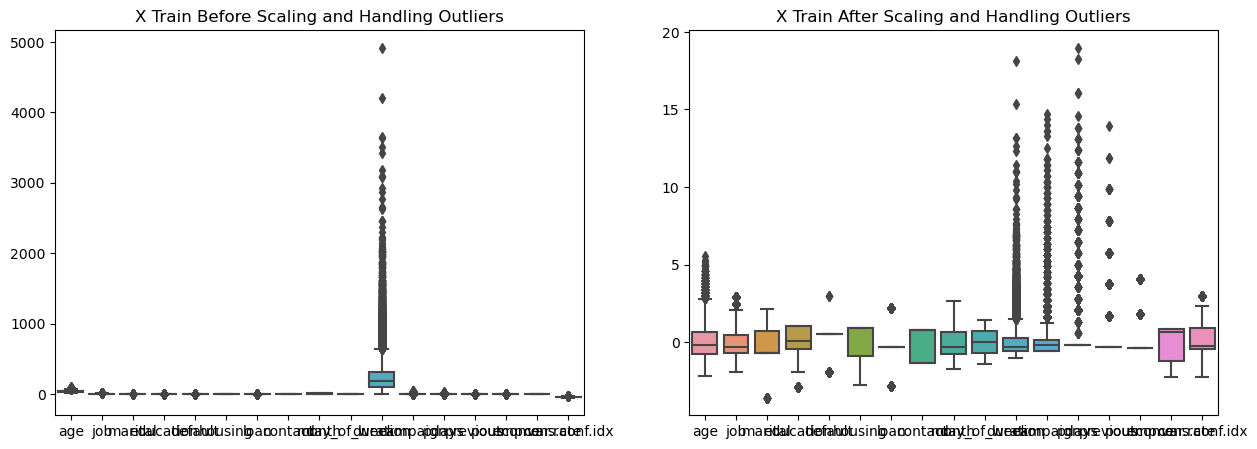

In [70]:
# Display the boxplot to compare before/after scaling
plt.subplots(figsize=(15,5))

plt.subplot(1,2,1)
sns.boxplot(data=x_train)
plt.title('X Train Before Scaling and Handling Outliers')

plt.subplot(1,2,2)
sns.boxplot(data=pd.DataFrame(X_train_sc,columns=X_train.columns))
# sns.boxplot(data=x_train_sc)
plt.title('X Train After Scaling and Handling Outliers')

#Regression

In [64]:
linreg=LinearRegression()
linreg.fit(X_train_sc,y_train)
y_pred=linreg.predict(X_test_sc)
mae=mean_absolute_error(y_test,y_pred)
score=r2_score(y_test,y_pred)
print("Mean absolute error", mae)
print("R2 Score", score)

Mean absolute error 0.16202705715643673
R2 Score 0.3088122883137725


In [87]:
def ModelEval(inAlgo=None,inActual=None,inPred=None,inFeature=None):
    
    # Cost Function
    print(f'{inAlgo} - Cost Function')
    print(f'MAE: {mean_absolute_error(inActual,inPred)}')
    print(f'MSE: {mean_squared_error(inActual,inPred)}')

    # Performance of the Model
    print(f'\n{inAlgo} - Performance')
    print(f'R2: {r2_score(inActual,inPred)}')
    print(f'Adjusted R2 {1 - (1-r2_score(inActual,inPred))*(len(inActual)-1)/(len(inActual)-inFeature.shape[1]-1)}')        
# Model Training Using Linear Regression

linear_reg = LinearRegression()

# Train the model using training data
model_lr = linear_reg.fit(X_train_sc, y_train)
print('Coeff:',model_lr.coef_)
print('Intercept:',model_lr.intercept_)
print()

# Predict the values of y
y_pred_lr = model_lr.predict(X_test_sc)

# Model Eval
ModelEval('Linear Regression',y_test,y_pred_lr,X_train_sc)

tp, fn, fp, tn = confusion_matrix(y_test,predict_test,labels=[1,0]).reshape(-1)

print('Outcome values testing data: \n\n')
print('True positive:',tp)
print('False positives:',fp)
print('True negative:',tn)
print('False negative:',fn)
print( sep='\n')
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,predict_test)
print('Classification report testing data: \n',matrix)
print("______________________________________________________________________")

Coeff: [ 0.00575539  0.00489443  0.00522126  0.00430008  0.00868359 -0.0014094
 -0.00202719  0.01065313  0.00129854  0.00177668  0.12230082  0.00331606
  0.04447725 -0.00761564  0.02514195 -0.07347413  0.03162386]
Intercept: 0.11220561201484512

Linear Regression - Cost Function
MAE: 0.16202705715643673
MSE: 0.06965297560921103

Linear Regression - Performance
R2: 0.3088122883137725
Adjusted R2 0.307860007650942
Outcome values testing data: 


True positive: 1405
False positives: 10916
True negative: 36
False negative: 0

Classification report testing data: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.01     10952
           1       0.11      1.00      0.20      1405

    accuracy                           0.12     12357
   macro avg       0.56      0.50      0.11     12357
weighted avg       0.90      0.12      0.03     12357

______________________________________________________________________


In [109]:
ridge=Ridge()
ridge.fit(X_train_sc,y_train)
y_pred=ridge.predict(X_test_sc)
mae=mean_absolute_error(y_test,y_pred)
score=r2_score(y_test,y_pred)
print("Mean absolute error", mae)
print("R2 Score", score)

TypeError: solve() got an unexpected keyword argument 'sym_pos'

In [103]:
ridgecv=RidgeCV()
ridgecv.fit(X_train_sc,y_train)
y_pred=ridgecv.predict(X_test_sc)
mae=mean_absolute_error(y_test,y_pred)
score=r2_score(y_test,y_pred)
print("Mean absolute error", mae)
print("R2 Score", score)

Mean absolute error 0.16202122453513568
R2 Score 0.3088137067590089


In [104]:
lassocv=LassoCV()
lassocv.fit(X_train_sc,y_train)
y_pred=lassocv.predict(X_test_sc)
mae=mean_absolute_error(y_test,y_pred)
score=r2_score(y_test,y_pred)
print("Mean absolute error", mae)
print("R2 Score", score)

Mean absolute error 0.1619934962964366
R2 Score 0.3088580229994585


In [105]:
lasso=Lasso()
lasso.fit(X_train_sc,y_train)
y_pred=lasso.predict(X_test_sc)
mae=mean_absolute_error(y_test,y_pred)
score=r2_score(y_test,y_pred)
print("Mean absolute error", mae)
print("R2 Score", score)

Mean absolute error 0.20039062700539992
R2 Score -2.2182525933445163e-05


In [106]:
elatic=ElasticNet()
elatic.fit(X_train_sc,y_train)
y_pred=elatic.predict(X_test_sc)
mae=mean_absolute_error(y_test,y_pred)
score=r2_score(y_test,y_pred)
print("Mean absolute error", mae)
print("R2 Score", score)

Mean absolute error 0.20039062700539992
R2 Score -2.2182525933445163e-05


In [84]:
lr=LogisticRegression(solver='lbfgs', max_iter=3000)

Test set results:
___________________________________________________________________
Confusion matrix : 



C:\Users\amini\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


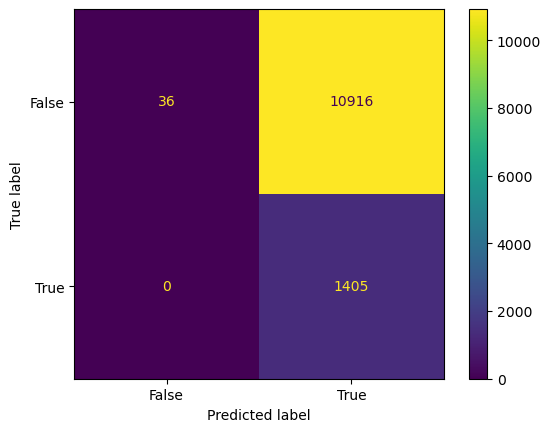


Outcome values testing data: 


True positive: 1405
False positives: 10916
True negative: 36
False negative: 0

Classification report testing data: 
               precision    recall  f1-score   support

           0       1.00      0.00      0.01     10952
           1       0.11      1.00      0.20      1405

    accuracy                           0.12     12357
   macro avg       0.56      0.50      0.11     12357
weighted avg       0.90      0.12      0.03     12357

______________________________________________________________________


In [85]:
model=lr.fit(X_train_sc,y_train)
predict_test=model.predict(x_test)
#Model Evaluation
# confusion matrix
matrix = confusion_matrix(y_test,predict_test)
print('Test set results:')
print("___________________________________________________________________")
print('Confusion matrix : \n')
from sklearn import metrics
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = matrix, display_labels = [False, True])
cm_display.plot()
plt.show()
print( sep='\n')
# outcome values order in sklearn


tp, fn, fp, tn = confusion_matrix(y_test,predict_test,labels=[1,0]).reshape(-1)

print('Outcome values testing data: \n\n')
print('True positive:',tp)
print('False positives:',fp)
print('True negative:',tn)
print('False negative:',fn)
print( sep='\n')
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(y_test,predict_test)
print('Classification report testing data: \n',matrix)
print("______________________________________________________________________")

In [91]:
from sklearn.tree import  DecisionTreeClassifier
clf=DecisionTreeClassifier()
clf.fit(X_train,y_train)
from sklearn import tree
plt.figure(figsize=(15,10));
from sklearn.metrics import confusion_matrix, r2_score, classification_report
y_pred=clf.predict(X_test)
print("?",confusion_matrix(y_test,y_pred))
print("r2_SCOR",r2_score(y_test,y_pred))
print(classification_report(y_test,y_pred))

? [[10225   727]
 [  660   745]]
r2_SCOR -0.11383214752696325
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     10952
           1       0.51      0.53      0.52      1405

    accuracy                           0.89     12357
   macro avg       0.72      0.73      0.73     12357
weighted avg       0.89      0.89      0.89     12357



<Figure size 1500x1000 with 0 Axes>

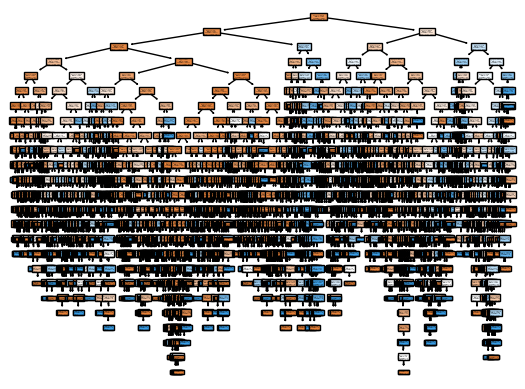

In [92]:
tree.plot_tree(clf,filled=True);

In [110]:
rf=RandomForestClassifier(n_estimators=100)
model=rf.fit(X_train_sc,y_train)
rf_test=model.predict(X_test_sc)

Test Set results: 


Confusion matrix testing data : 



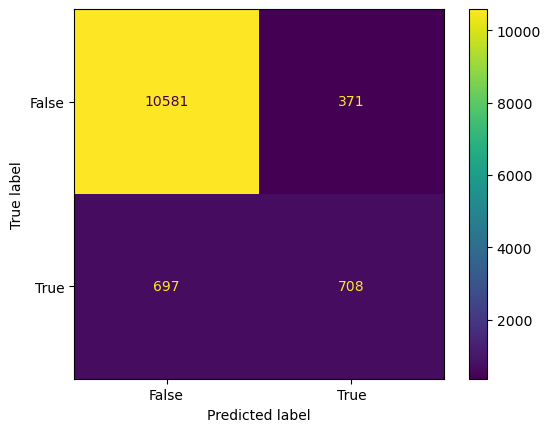

Outcome values testing data : 

True positive: 708
False positives: 371
True negative: 10581
False negative: 697

Classification report testing data: 
               precision    recall  f1-score   support

           0       0.94      0.97      0.95     10952
           1       0.66      0.50      0.57      1405

    accuracy                           0.91     12357
   macro avg       0.80      0.74      0.76     12357
weighted avg       0.91      0.91      0.91     12357



In [111]:
rf_matrix = confusion_matrix(y_test,rf_test)
print('Test Set results: \n\n')
print('Confusion matrix testing data : \n')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = rf_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(y_test,rf_test,labels=[1,0]).reshape(-1)

print('Outcome values testing data : \n')
print('True positive:',tp)
print('False positives:',fp)
print('True negative:',tn)
print('False negative:',fn)
print( sep='\n')

# classification report for precision, recall f1-score and accuracy
rf_matrix = classification_report(y_test,rf_test)
print('Classification report testing data: \n',rf_matrix)

In [ ]:
### Artificial Neural Network (ANN)
- Implement a simple ANN for regression using a framework like TensorFlow or Keras.
- Design the architecture of the neural network, including the input and output layers.
- Train the ANN on the training set.
- Make predictions on the testing set.
- Evaluate the model's performance using the same regression metrics used for Linear Regression.

X Train - ANN: (23064, 17)
Y Train - ANN: (23064,)
X Valid - ANN: (5767, 17)
Y Valid - ANN: (5767,)
Layers:

[<keras.layers.core.dense.Dense object at 0x000001E2660AA250>, <keras.layers.core.dense.Dense object at 0x000001E265DA74C0>, <keras.layers.core.dense.Dense object at 0x000001E2610FC0A0>, <keras.layers.core.dense.Dense object at 0x000001E26ACD2A00>]


Summary:

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 50)                900       
                                                                 
 hiddenLayer1 (Dense)        (None, 30)                1530      
                                                                 
 hiddenLayer2 (Dense)        (None, 10)                310       
                                                                 
 outputLayer (Dense)         (None, 1)                 11        
             

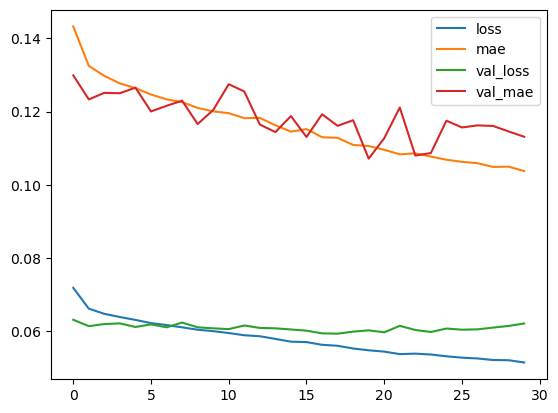

In [99]:
# Split the data intro training and validation sets
x_train_ann, x_valid_ann, y_train_ann, y_valid_ann = train_test_split(X_train_sc,y_train,test_size=0.2,random_state=1234)

print('X Train - ANN:',x_train_ann.shape)
print('Y Train - ANN:',y_train_ann.shape)
print('X Valid - ANN:',x_valid_ann.shape)
print('Y Valid - ANN:',y_valid_ann.shape)
# Set up the layers of ANN
ann_layers = [tf.keras.layers.Dense(units=50, input_shape=x_train_ann.shape[1:], activation='relu'),
              tf.keras.layers.Dense(units=30, activation="relu", kernel_initializer='uniform', name="hiddenLayer1"),
              tf.keras.layers.Dense(units=10, activation="relu", kernel_initializer='uniform', name="hiddenLayer2"),
            #   tf.keras.layers.Dense(units=10, activation="relu", kernel_initializer='uniform', name="hiddenLayer3"),
              tf.keras.layers.Dense(units=1, activation="linear", kernel_initializer='uniform', name="outputLayer")]

model_ann = tf.keras.models.Sequential(ann_layers)

print('Layers:\n')
print(model_ann.layers)
print('\n\nSummary:\n')
print(model_ann.summary())
# Compile the ANN model
model_ann.compile(loss='mse',
                  optimizer="adam",
                  metrics=['mae']
                  )

# Model Training Using ANN
history = model_ann.fit(x_train_ann, y_train_ann, epochs=30,
                        validation_data=(x_valid_ann, y_valid_ann),
                        batch_size=32)

# Plot
pd.DataFrame(history.history).plot()
# Predict the values of y
y_pred_ann = model_ann.predict(X_test_sc, verbose=0)

# Model Eval
ModelEval('ANN',y_test,y_pred_ann,X_train_sc)

X Train - ANN: (23064, 17)
Y Train - ANN: (23064,)
X Valid - ANN: (5767, 17)
Y Valid - ANN: (5767,)
Layers:

[<keras.layers.core.dense.Dense object at 0x000001E26222EAF0>, <keras.layers.core.dense.Dense object at 0x000001E26B5505E0>, <keras.layers.core.dense.Dense object at 0x000001E26AD759D0>, <keras.layers.core.dense.Dense object at 0x000001E26AD75A30>, <keras.layers.core.dense.Dense object at 0x000001E26AD751F0>]


Summary:

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 50)                900       
                                                                 
 hiddenLayer1 (Dense)        (None, 30)                1530      
                                                                 
 hiddenLayer2 (Dense)        (None, 10)                310       
                                                                 
 hiddenLayer3 (De

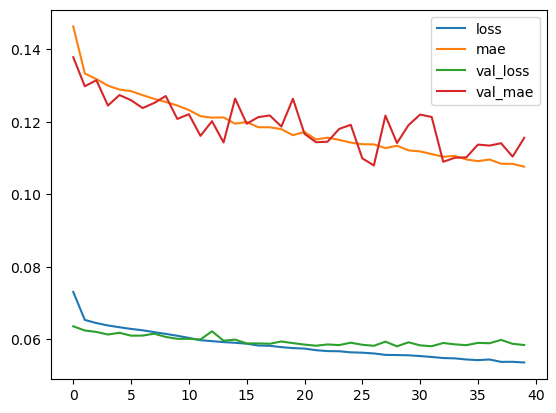

In [108]:
# Split the data intro training and validation sets
x_train_ann, x_valid_ann, y_train_ann, y_valid_ann = train_test_split(X_train_sc,y_train,test_size=0.2,random_state=1234)

print('X Train - ANN:',x_train_ann.shape)
print('Y Train - ANN:',y_train_ann.shape)
print('X Valid - ANN:',x_valid_ann.shape)
print('Y Valid - ANN:',y_valid_ann.shape)
# Set up the layers of ANN
ann_layers = [tf.keras.layers.Dense(units=50, input_shape=x_train_ann.shape[1:], activation='relu'),
              tf.keras.layers.Dense(units=30, activation="tanh", kernel_initializer='uniform', name="hiddenLayer1"),
              tf.keras.layers.Dense(units=10, activation="sigmoid", kernel_initializer='uniform', name="hiddenLayer2"),
              tf.keras.layers.Dense(units=10, activation="softsign", kernel_initializer='uniform', name="hiddenLayer3"),
              tf.keras.layers.Dense(units=1, activation="linear", kernel_initializer='uniform', name="outputLayer")]

model_ann = tf.keras.models.Sequential(ann_layers)

print('Layers:\n')
print(model_ann.layers)
print('\n\nSummary:\n')
print(model_ann.summary())
# Compile the ANN model
model_ann.compile(loss='mse',
                  optimizer="adam",
                  metrics=['mae']
                  )

# Model Training Using ANN
history = model_ann.fit(x_train_ann, y_train_ann, epochs=40,
                        validation_data=(x_valid_ann, y_valid_ann),
                        batch_size=32)

# Plot
pd.DataFrame(history.history).plot()
# Predict the values of y
y_pred_ann = model_ann.predict(X_test_sc, verbose=0)

# Model Eval
ModelEval('ANN',y_test,y_pred_ann,X_train_sc)